In [12]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

from tqdm.auto import tqdm

from torchmetrics import Accuracy

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [13]:
train_data = datasets.FashionMNIST(root="data",
                                    train=True,
                                    download=True,
                                    transform=ToTensor(),
                                    target_transform=None)

test_data = datasets.FashionMNIST(root="data",
                                    train=False,
                                    download=True,
                                    transform=ToTensor(),
                                    target_transform=None)

In [14]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

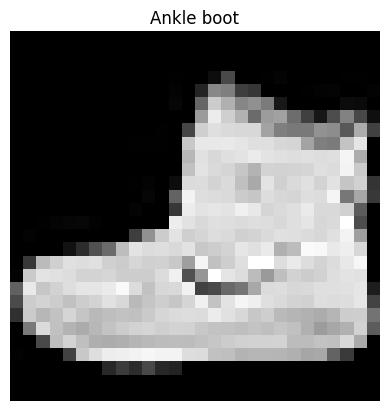

In [15]:
class_names = train_data.classes
image, label = train_data[0]

fig, ax = plt.subplots()

ax.imshow(image.squeeze(), cmap="gray")
ax.set_title(class_names[label])
ax.axis(False)
train_data.targets.unique()


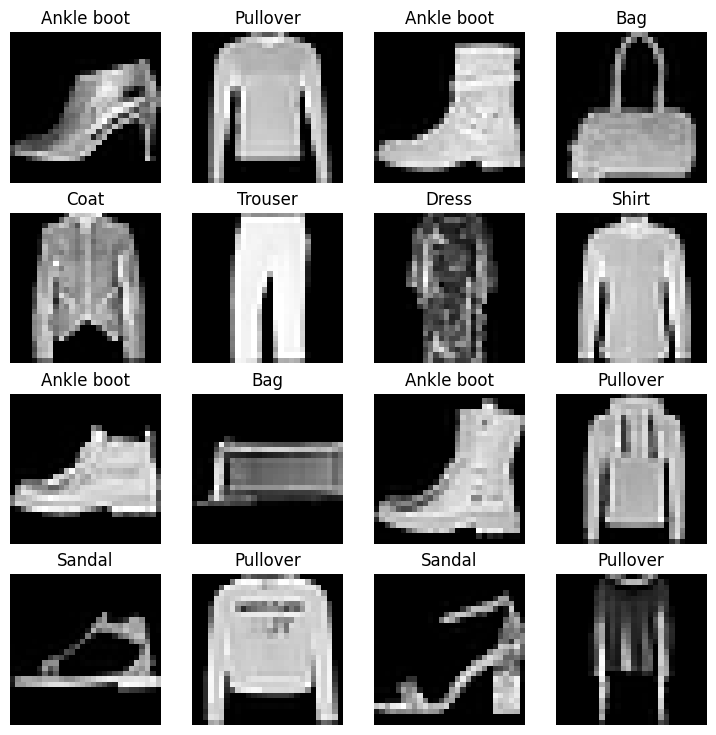

In [16]:
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(9, 9)


for ax in axs.flatten():
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(class_names[label])
    ax.axis(False)


In [17]:
BATCH_SIZE = 128

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_featues_batch, train_labels_batch = next(iter(train_dataloader))
train_featues_batch.shape, train_labels_batch.shape

train_dataloader

In [188]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn,
               device="cuda"):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y_pred, y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc.item()
    }

In [178]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn: torch.nn.Module,
               device: torch.device = "cuda"):

    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        # print(y_pred.argmax(dim=1))

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {100 * train_acc:.5f}%")

In [20]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              acc_fn,
              device: torch.device = "cuda"):


    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += acc_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.4f}, Test acc: {100 * test_acc:.4f}")

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
                        nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [22]:
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
#next(model_2.parameters()).shape
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [23]:
# rand_img_tensor = torch.randn(size=(1, 28, 28)).to(device)
# model_2(rand_img_tensor.unsqueeze(0))

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=10).to(device)

In [25]:
from timeit import default_timer as timer
start = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               acc_fn=acc_fn,
               device=device)
    test_step(model=model_2,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               acc_fn=acc_fn,
               device=device)
end = timer()
print(end - start)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.72542 | Train acc: 73.43417%


 33%|███▎      | 1/3 [00:16<00:33, 16.68s/it]

Test loss: 0.4612, Test acc: 83.5490
Train loss: 0.38586 | Train acc: 85.97415%


 67%|██████▋   | 2/3 [00:28<00:13, 13.92s/it]

Test loss: 0.3662, Test acc: 86.7536
Train loss: 0.33890 | Train acc: 87.82983%


100%|██████████| 3/3 [00:41<00:00, 13.73s/it]

Test loss: 0.3715, Test acc: 86.1067
41.19878640002571


In [26]:
model_2_results = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            acc_fn=acc_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.37153202295303345,
 'model_acc': 0.8610668778419495}

In [27]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = "cuda"):
    pred_probs = []
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Add a batch dimension and pass to target device
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [28]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

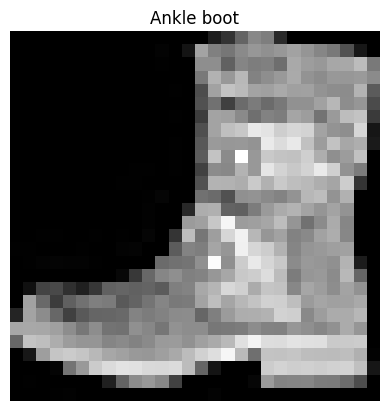

In [29]:
plt.imshow(test_samples[1].squeeze(), cmap="gray")
plt.title(class_names[test_labels[1]])
plt.axis(False)

In [30]:
pred_probs = make_predictions(model_2,
                              data=test_samples,
                              device=device)
pred_probs[:2]

tensor([[2.7267e-09, 6.9527e-11, 2.3177e-09, 8.8304e-10, 3.0243e-09, 1.4399e-05,
         3.4712e-07, 8.0777e-06, 1.8549e-06, 9.9998e-01],
        [2.3067e-07, 3.0532e-07, 1.0527e-07, 7.4887e-08, 2.6494e-08, 8.8081e-04,
         4.2448e-06, 3.1421e-05, 7.4911e-05, 9.9901e-01]])

In [31]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([9, 9, 4, 4, 5, 6, 7, 5, 9]), [9, 9, 4, 2, 5, 6, 7, 5, 9])

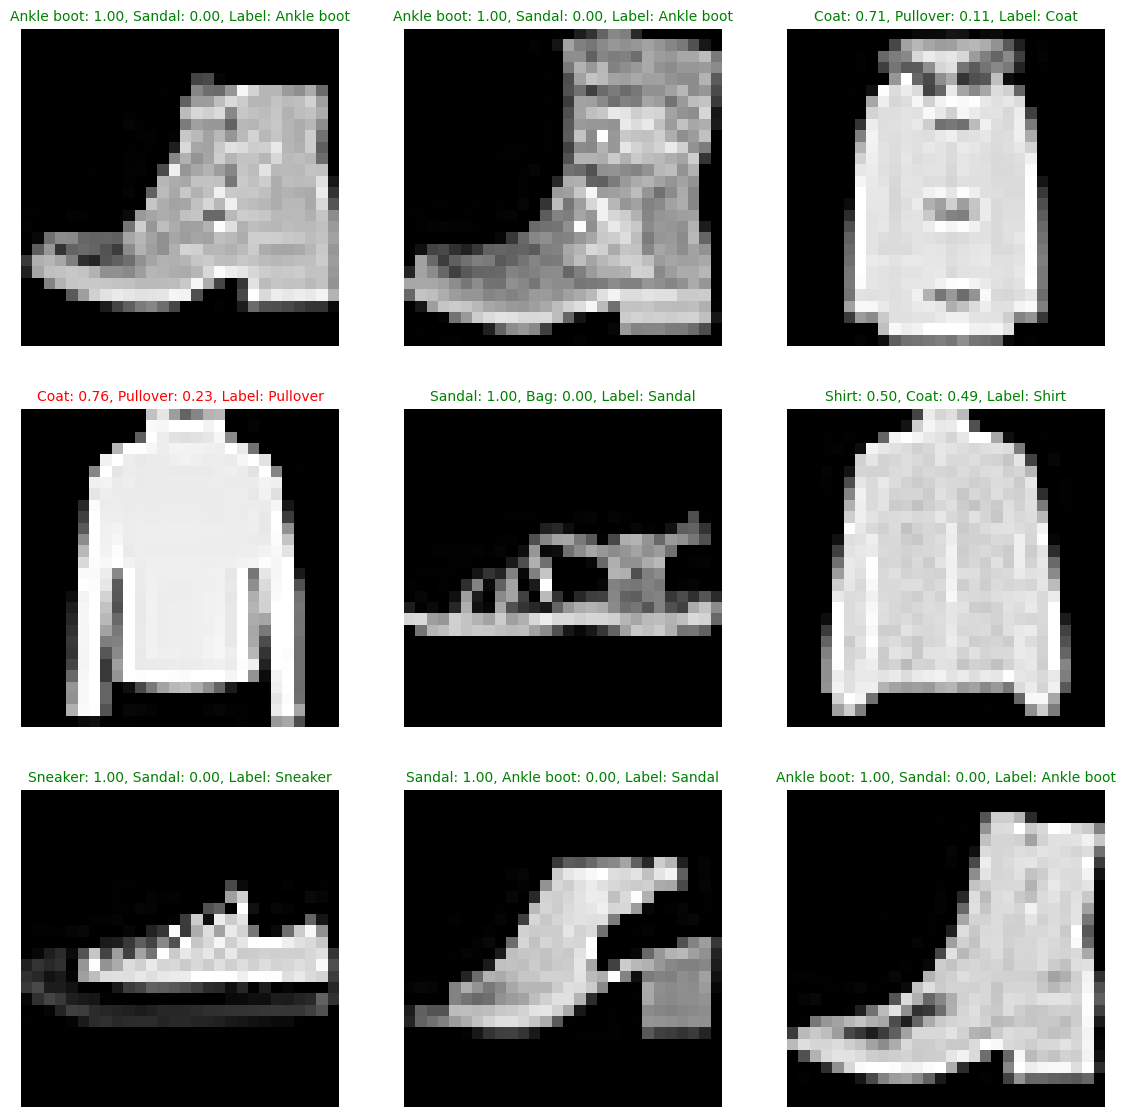

In [32]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(14, 14)

for ax, sample, label_true, label_test, prob in zip(axs.flatten(), test_samples, test_labels, pred_classes, pred_probs):
    ax.axis(False)
    ax.imshow(sample.squeeze(), cmap="gray")
    prob, idx = prob.topk(2)

    prob = [ '%.2f' % elem for elem in prob ]
    title = f"{class_names[idx[0].item()]}: {prob[0]}, {class_names[idx[1].item()]:}: {prob[1]}, Label: {class_names[label_true]}"


    if label_true == label_test:
        ax.set_title(title, c="g", fontsize=10)
    else:
        ax.set_title(title, c="r", fontsize=10)

In [193]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1).cpu()
        y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...: 100%|██████████| 157/157 [00:01<00:00, 126.75it/s]


(tensor([9, 2, 1, 1, 6, 3, 4, 6, 5, 7]), 10000)

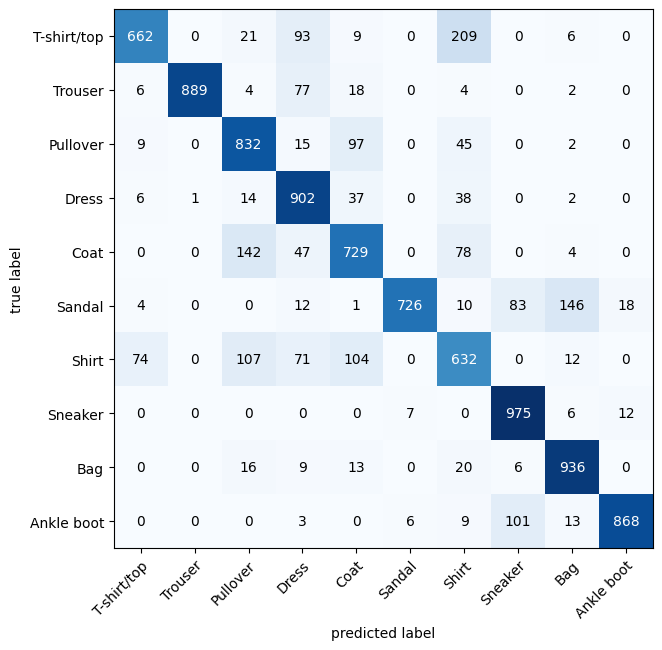

In [194]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(num_classes=10, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
confmat_tensor

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                show_absolute=True,
                                show_normed=False,
                                class_names=class_names,
                                figsize=(10, 7))


In [199]:
from torchvision.models import resnet50, ResNet18_Weights
import torchvision.transforms as T

class FashionMNISTModelV3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet18 = resnet50(weights=None)
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)
        self.transform = T.Normalize(mean=[0.456], std=[0.224])

    def forward(self, x):
        # x = self.transform(x)
        x = x.to(self.resnet18.conv1.weight.device)
        return self.resnet18(x)
        

In [200]:
model_3 = FashionMNISTModelV3(10).to(device)
print(model_3)

model_3.eval()
with torch.inference_mode():
    rand_tensor = torch.randn(1, 1, 28, 28)
    y_pred = model_3(rand_tensor)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=10).to(device)


FashionMNISTModelV3(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [207]:
epochs = 1

for epoch in tqdm(range(epochs)):
    train_step(model=model_3,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               acc_fn=acc_fn,
               device=device)
    test_step(model=model_3,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               acc_fn=acc_fn,
               device=device)
    

  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.03358 | Train acc: 98.86395%


100%|██████████| 1/1 [01:12<00:00, 72.05s/it]

Test loss: 0.3572, Test acc: 92.2671


In [208]:
model_3_results = eval_model(model=model_3,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            acc_fn=acc_fn)
model_3_results

{'model_name': 'FashionMNISTModelV3',
 'model_loss': 0.3571549952030182,
 'model_acc': 0.9226711988449097}

In [209]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_3(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1).cpu()
        y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...: 100%|██████████| 157/157 [00:04<00:00, 36.08it/s]


(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

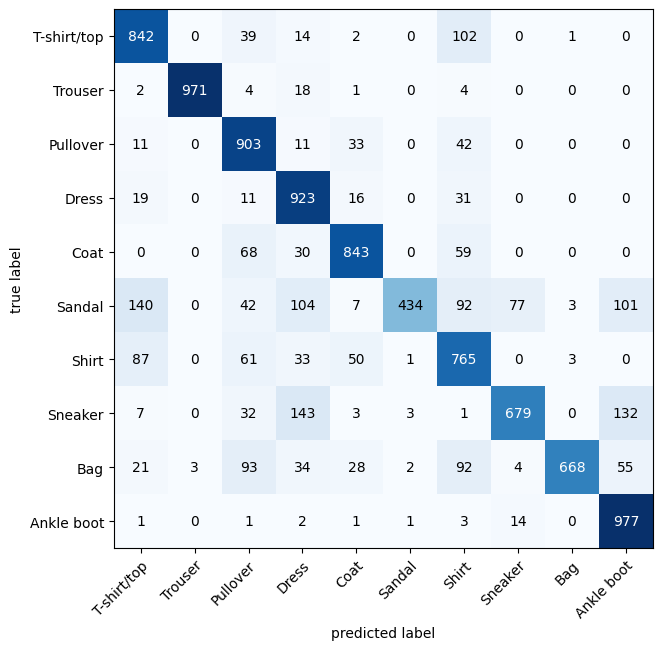

In [210]:
confmat = ConfusionMatrix(num_classes=10, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
confmat_tensor

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                show_absolute=True,
                                show_normed=False,
                                class_names=class_names,
                                figsize=(10, 7))